In [39]:
import sys
sys.path.append('./src/')

import numpy as np
import pandas as pd

from src.benchmarks import Naive2
from src.utils_data import M4_parser, prepare_M4_data

In [43]:
X_train_df, y_train_df, X_test_df, y_test_df = M4_parser('Monthly', 10)

In [45]:
y_df = y_train_df[y_train_df.unique_id=='M1']
y_hat_df = y_test_df[y_test_df.unique_id=='M1']

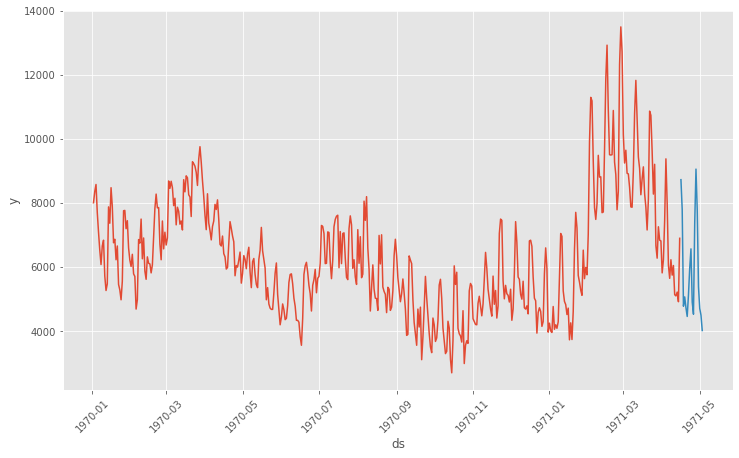

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_prediction(y_df, y_hat_df):
    """
    y_df: pandas df
    panel with columns unique_id, ds, y
    y_hat_df: pandas df
    panel with columns unique_id, ds, y_hat
    """
    pd.plotting.register_matplotlib_converters()
    
    plt.figure(figsize=(12,7))

    sns.lineplot(x='ds', y='y', data=y_df)
    sns.lineplot(x='ds', y='y', data=y_hat_df)
    plt.xticks(rotation=45)

plot_prediction(y_df=y_df, y_hat_df=y_hat_df)